In [1]:
import pathlib
import os
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

import random

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
batch_size = 2

In [4]:
# load the images and masks
dir_images_train = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/train/images')
dir_masks_train = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/train/masks')
dir_images_test = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/test/images')
dir_masks_test = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/test/masks')

In [5]:
train_ids = [f.stem for f in dir_images_train.glob("*.jpg")]
test_ids = [f.stem for f in dir_images_test.glob("*.jpg")]

In [6]:
train_ids = train_ids[:batch_size*100]#*100
#test_ids = test_ids[:batch_size*20]

In [7]:
len(train_ids), len(test_ids)

(200, 182)

In [8]:
class KvasirSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, ids, transform=None):
        """
        Args:
            image_dir (pathlib.Path): Directory with all the images.
            mask_dir (pathlib.Path): Directory with all the masks.
            pca_data (pd.DataFrame): DataFrame containing PCA features.
            ids (list): List of image/mask IDs (without extensions).
            transform (callable, optional): Optional additional transform to be applied on an image/mask.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.ids = ids
        self.transform = transform
        self.to_tensor = ToTensor()  # Define ToTensor transformation

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        name = self.ids[idx]
        # Load image and mask
        image = np.array(Image.open(self.image_dir / f"{name}.jpg").convert("RGB"))
        
        mask = np.array(Image.open(self.mask_dir / f"{name}.jpg").convert("L")) / 255
        #mask = np.array(mask)

        # Apply ToTensor transformation
        #image = self.to_tensor(image)
        #mask = self.to_tensor(mask)


        ## Apply additional transformations if provided
        #if self.transform:
        #    image = self.transform(image)
        #    mask = self.transform(mask)

        return image, mask


In [9]:
# Create datasets with transformations
dataset_train = KvasirSegDataset(dir_images_train, dir_masks_train, train_ids)
dataset_test = KvasirSegDataset(dir_images_test, dir_masks_test, test_ids)

# Create dataloaders
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4)

In [10]:
for images, masks in train_loader:
    print(images[0].shape)
    print(images[0])
    break

torch.Size([128, 128, 3])
tensor([[[0, 0, 9],
         [0, 0, 7],
         [0, 0, 7],
         ...,
         [3, 0, 0],
         [1, 0, 2],
         [1, 0, 2]],

        [[0, 0, 9],
         [0, 0, 7],
         [0, 0, 5],
         ...,
         [3, 0, 0],
         [1, 0, 2],
         [1, 0, 2]],

        [[0, 0, 7],
         [0, 0, 5],
         [0, 0, 5],
         ...,
         [3, 0, 0],
         [3, 0, 0],
         [3, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 3, 0],
         [0, 3, 0],
         [0, 4, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 3, 0],
         [0, 4, 0],
         [0, 5, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 4, 0],
         [0, 4, 0],
         [0, 5, 0]]], dtype=torch.uint8)


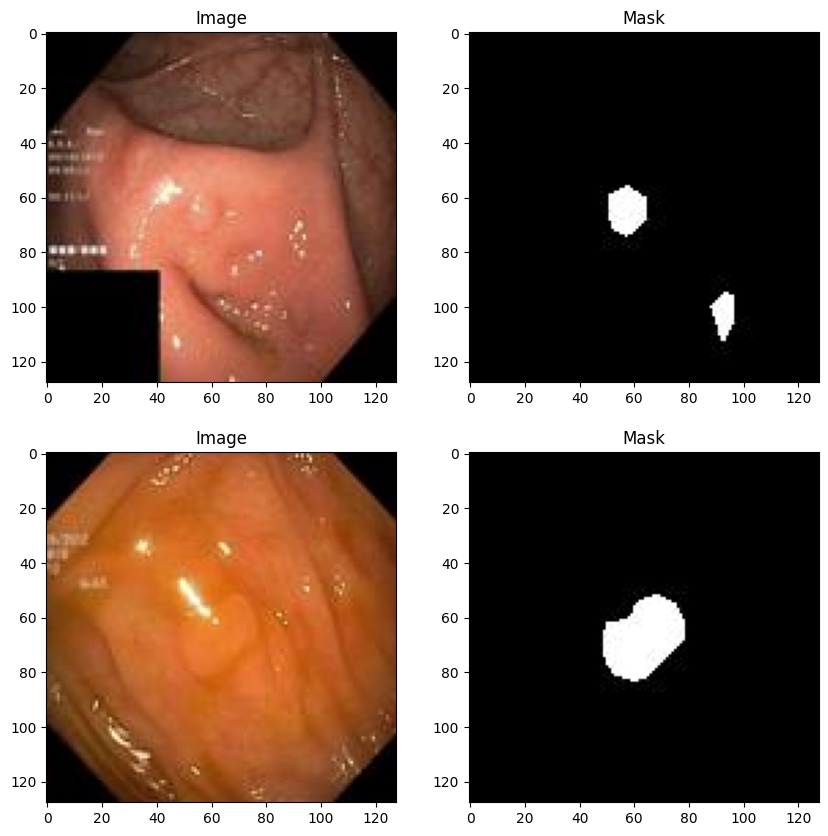

In [11]:
# plot the images and masks
def plot_images_and_masks(images, masks):
    num_images = len(images)
    fig, axs = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
    for i in range(num_images):
        axs[i, 0].imshow(images[i])
        axs[i, 0].set_title("Image")
        axs[i, 1].imshow(masks[i], cmap='gray')
        axs[i, 1].set_title("Mask")
    plt.show()
# Get a batch of images and masks
for images, masks in train_loader:
    plot_images_and_masks(images, masks)
    break

In [12]:
class CustomModel(torch.nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        # Convolutional layers
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)  
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1) 
        self.conv4 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = torch.nn.Linear(256 * 32 * 32, 256 *2)  # Match the flattened size
        self.fc2 = torch.nn.Linear(2 * 256, 2 * 128)
        self.fc3 = torch.nn.Linear(2 * 128, 2)

        # Activations
        self.tanh = torch.nn.Tanh()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        # Normalize input by dividing by 255
        x = x / 255.0
        # Convolutional layers with activation and pooling
        x = self.tanh(self.conv1(x))
        x = self.pool(self.tanh(self.conv2(x)))
        x = self.tanh(self.conv3(x))
        x = self.pool(self.tanh(self.conv4(x)))

        # Flatten for fully connected layers
        x = x.reshape(x.size(0), -1)  # Flatten dynamically

        # Fully connected layers
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.sigmoid(self.fc3(x))

        x = (x * 128) - 1
        return x

# Instantiate the model
model = CustomModel()
model.to(device)

CustomModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=262144, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
)

In [13]:
# test model with a random input
#x = torch.randn(512).to(device)
x = torch.rand(1, 3, 128, 128).to(device)
y = model(x)
print(y)

tensor([[61.7589, 60.7588]], device='cuda:0', grad_fn=<SubBackward0>)


In [14]:
# test model with the first image from the train dataset
for i, (image, mask) in enumerate(train_loader):
    image = image.to(device).permute(0, 3, 1, 2)
    #print(image.shape)
    y = model(image)
    print(y.int())
    break

tensor([[62, 60],
        [61, 60]], device='cuda:0', dtype=torch.int32)


In [15]:
image[0].shape

torch.Size([3, 128, 128])

In [16]:
mask[0].shape

torch.Size([128, 128])

In [17]:
mask[0].max(), mask[0].min()

(tensor(1., dtype=torch.float64), tensor(0., dtype=torch.float64))

In [18]:
# build the sam2 model
sam2_checkpoint = "../../sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

In [19]:
# test the sam2 model with the first image from the train dataset
for i, (images, target_masks) in enumerate(train_loader):
    images_original = images.clone()
    images = images.to(device).permute(0, 3, 1, 2)
    y = model(images).int()
    #print(y)
    prompt_labels = torch.ones((y.shape[0], 1))
    #print(prompt_labels)
    #print(np.array(images).shape)
    images_list = [ np.array(image) for image in images_original ]
    coords_list = [ [y[i].tolist(), [128,128], [128,0], [0,128], [0,0]] for i in range(y.shape[0]) ]
    labels_list = [ prompt_labels[i].tolist() + [0.]*4 for i in range(prompt_labels.shape[0]) ]

    predictor.set_image_batch(images_list)
    #print(y.unsqueeze(0))
    #print(prompt_labels[i])
    masks, _, _ = predictor.predict_batch(point_coords_batch=coords_list, point_labels_batch=labels_list, multimask_output=False)
    break

In [20]:
target_masks = np.array(target_masks)
target_masks.shape

(2, 128, 128)

In [21]:
target_masks[0].shape

(128, 128)

In [22]:
target_masks[0].max(), target_masks[0].min()

(1.0, 0.0)

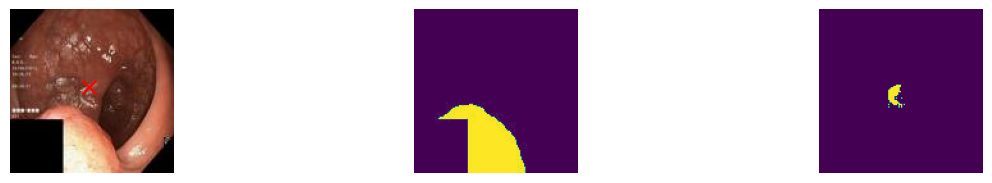

In [23]:
# visualize original images, prompt points, target masks and predicted masks
plt.figure(figsize=(20, 20))
for i in range(1):
    plt.subplot(8, 4, 4 * i + 1)
    plt.imshow(images_original[i])
    plt.scatter(y[i][0].cpu(), y[i][1].cpu(), c="r", s=100, marker="x")
    plt.axis("off")
    plt.subplot(8, 4, 4 * i + 2)
    plt.imshow(target_masks[i])
    plt.axis("off")
    plt.subplot(8, 4, 4 * i + 3)
    plt.imshow(masks[i].transpose(1, 2, 0))
    plt.axis("off")
plt.show()

In [24]:
target_masks.shape

(2, 128, 128)

In [25]:
target_masks[0].max(), target_masks[0].min()

(1.0, 0.0)

In [26]:
# plot distribution of target masks
#plt.hist(target_masks[0].flatten(), bins=20)
#plt.show()

In [27]:
np.sum(target_masks[0], axis=1).shape

(128,)

In [28]:
torch.cuda.empty_cache()

In [29]:
# Hyperparameters
num_epochs = 50
learning_rate = 0.00001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.train()

dict_log = {
    "epoch": [],
    "loss": [],
    "mean_distance": [],
    "mean_reward": [],
    "mean_iou": [],
}
box_size = 24
# Training Loop
for epoch in range(num_epochs):
    reward_batches = []
    iou_batches = []
    loss_batches = []
    distances_batches = []
    for i, (images, target_masks) in enumerate(train_loader):
        target_masks = np.array(target_masks)
        images_original = images.clone()
        images = images.to(device).permute(0, 3, 1, 2)
        points = model(images)
        #print("points ", points)
        
        prompt_labels = torch.ones((points.shape[0], 1))
        images_list = [ np.array(image) for image in images_original ]
        # create boxes around the points
        boxes_list = [ [points[i][0].int()-box_size, points[i][1].int()-box_size, points[i][0].int()+box_size, points[i][1].int()+box_size] for i in range(points.shape[0]) ]

        predictor.set_image_batch(images_list)
        masks, _, _ = predictor.predict_batch(box_batch=boxes_list, multimask_output=False)
        masks = np.array(masks).squeeze(1)

        # 1. Compute rewards (Intersection over Union)
        rewards = torch.zeros(batch_size).to(device)
        ious = torch.zeros(batch_size).to(device)
        for j in range(batch_size):
            intersection = np.minimum(masks[j], target_masks[j]).sum()
            union = np.maximum(masks[j], target_masks[j]).sum()
            iou = intersection / union
            ious[j] = iou
            rewards[j] = (iou + 1) # Reward function
        reward_batches.append(rewards.mean().item())
        iou_batches.append(ious.mean().item())
        
        rewards = rewards.detach()
        #print("Rewards: ", rewards)

        #select a random points from target_masks with value 1, at the x coordinate and y coordinate the value is 1
        indices = [np.argwhere(target_masks[j] == 1) for j in range(batch_size)]
        random_points = torch.tensor(np.array([random.choice(pts) for pts in indices])).to(device)
        # switch the x and y coordinates
        random_points = random_points[:, [1, 0]]

        # calculate loss
        distances = torch.sqrt((points - random_points) ** 2).sum(dim=1) + 1
        loss = torch.mean((1/(rewards)) * distances)
        loss_batches.append(loss.item())
        distances_batches.append(distances.mean().item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Logging
    mean_reward = np.mean(reward_batches)
    mean_iou = np.mean(iou_batches)
    mean_loss = np.mean(loss_batches)
    mean_distance = np.mean(distances_batches)
    dict_log["epoch"].append(epoch)
    dict_log["loss"].append(mean_loss)
    dict_log["mean_distance"].append(mean_distance)
    dict_log["mean_reward"].append(mean_reward)
    dict_log["mean_iou"].append(mean_iou)
    print(f"Epoch {epoch+1}: Loss = {mean_loss}, Mean distance = {mean_distance}, Mean Reward = {mean_reward}, Mean IOU = {mean_iou} \n")

Epoch 1: Loss = 37.47036893844604, Mean distance = 42.333626670837404, Mean Reward = 1.213293353319168, Mean IOU = 0.2132933579038945 

Epoch 2: Loss = 32.966647748947146, Mean distance = 37.879364776611325, Mean Reward = 1.2397039878368377, Mean IOU = 0.23970398670528084 

Epoch 3: Loss = 32.26196650505066, Mean distance = 37.55006214141846, Mean Reward = 1.2577902114391326, Mean IOU = 0.25779020516813034 

Epoch 4: Loss = 32.60762105464935, Mean distance = 38.011255722045895, Mean Reward = 1.2679226362705232, Mean IOU = 0.26792264076997524 

Epoch 5: Loss = 32.37754227638245, Mean distance = 37.84003047943115, Mean Reward = 1.2821670615673064, Mean IOU = 0.2821670668148727 

Epoch 6: Loss = 29.59226948738098, Mean distance = 35.0809229850769, Mean Reward = 1.2914153778553008, Mean IOU = 0.2914153739686299 

Epoch 7: Loss = 29.503410148620606, Mean distance = 35.35369689941406, Mean Reward = 1.2974230456352234, Mean IOU = 0.29742304624618554 

Epoch 8: Loss = 28.44700144767761, Mean d

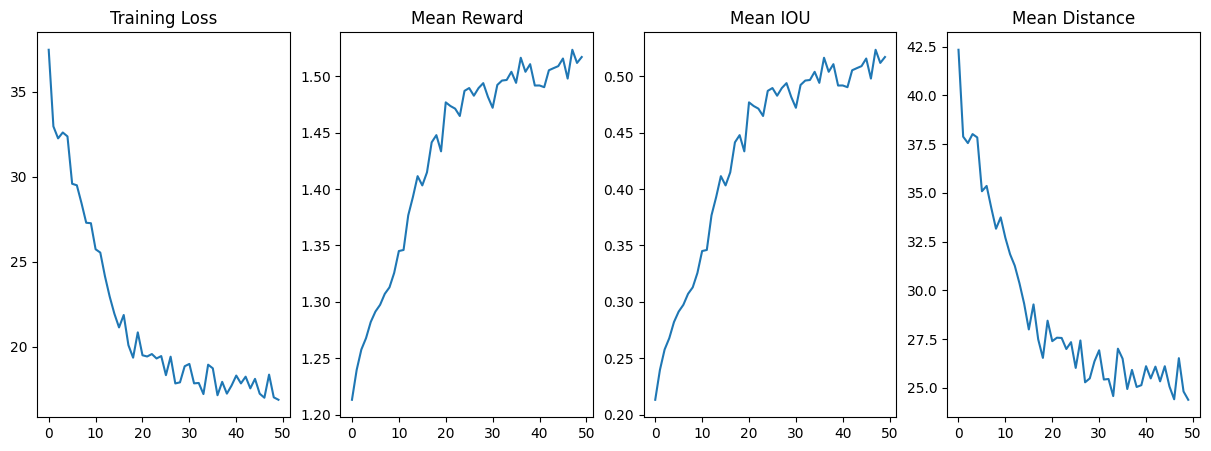

In [30]:
# Plot the training loss, mean reward and mean iou in different subplots
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.plot(dict_log["epoch"], dict_log["loss"])
plt.title("Training Loss")
plt.subplot(1, 4, 2)
plt.plot(dict_log["epoch"], dict_log["mean_reward"])
plt.title("Mean Reward")
plt.subplot(1, 4, 3)
plt.plot(dict_log["epoch"], dict_log["mean_iou"])
plt.title("Mean IOU")
#plot also mean distance
plt.subplot(1, 4, 4)
plt.plot(dict_log["epoch"], dict_log["mean_distance"])
plt.title("Mean Distance")
plt.show()
# save the figure
#plt.savefig("../../output/train_DQN_test1/training_plot.png")

In [31]:
# create a dataframe with the training logs and calculate the kendall correlation between variables
df_log = pd.DataFrame(dict_log)
df_log.corr(method="kendall")

,epoch,loss,mean_distance,mean_reward,mean_iou
epoch,1.000000,-0.822041,-0.779592,0.871020,0.871020
loss,-0.822041,1.000000,0.951020,-0.813878,-0.813878
mean_distance,-0.779592,0.951020,1.000000,-0.781224,-0.781224
mean_reward,0.871020,-0.813878,-0.781224,1.000000,1.000000
mean_iou,0.871020,-0.813878,-0.781224,1.000000,1.000000


In [32]:
df_log.corr(method="pearson")

,epoch,loss,mean_distance,mean_reward,mean_iou
epoch,1.000000,-0.860814,-0.864072,0.902023,0.902023
loss,-0.860814,1.000000,0.997544,-0.983892,-0.983892
mean_distance,-0.864072,0.997544,1.000000,-0.976677,-0.976677
mean_reward,0.902023,-0.983892,-0.976677,1.000000,1.000000
mean_iou,0.902023,-0.983892,-0.976677,1.000000,1.000000


In [33]:
# remove from the device all but except the models
model.cpu()
sam2_model.cpu()
device = "cpu"

In [ ]:
# test the model on the test dataset and calculate the mean iou
model.eval()
ious = torch.zeros(len(test_loader)).to(device)
points_list = []
masks_list = []
ious_list = []
images_list_mem = []
target_masks_list = []

for i, (images, target_masks) in enumerate(test_loader):
    if i < 36:
        images_list_mem.append(images)
        target_masks_list.append(target_masks)
    target_masks = np.array(target_masks)
    images_original = images.cpu().clone()
    images = images.to(device).permute(0, 3, 1, 2)
    points = model(images)

    images_list = [ np.array(image) for image in images_original ]
    boxes_list = [ [points[i][0].int()-box_size, points[i][1].int()-box_size, points[i][0].int()+box_size, points[i][1].int()+box_size] for i in range(points.shape[0]) ]

    predictor.set_image_batch(images_list)
    masks, _, _ = predictor.predict_batch(box_batch=boxes_list, multimask_output=True)
    #masks = np.array(masks).squeeze(1)
    if i < 36:
        masks_list.append(masks)
        points_list.append(points)

    # 1. Compute Intersection over Union
    intersection = np.minimum(masks, target_masks).sum()
    union = np.maximum(masks, target_masks).sum()
    iou = intersection / union
    
    ious_list.append(iou)

In [54]:
# calculate the mean iou and the std of the ious
ious = torch.tensor(ious_list)
ious.mean(), ious.std(), ious.max(), ious.min(), ious.median()

(tensor(0.2138, dtype=torch.float64),
 tensor(0.1596, dtype=torch.float64),
 tensor(0.6442, dtype=torch.float64),
 tensor(0.0006, dtype=torch.float64),
 tensor(0.1641, dtype=torch.float64))

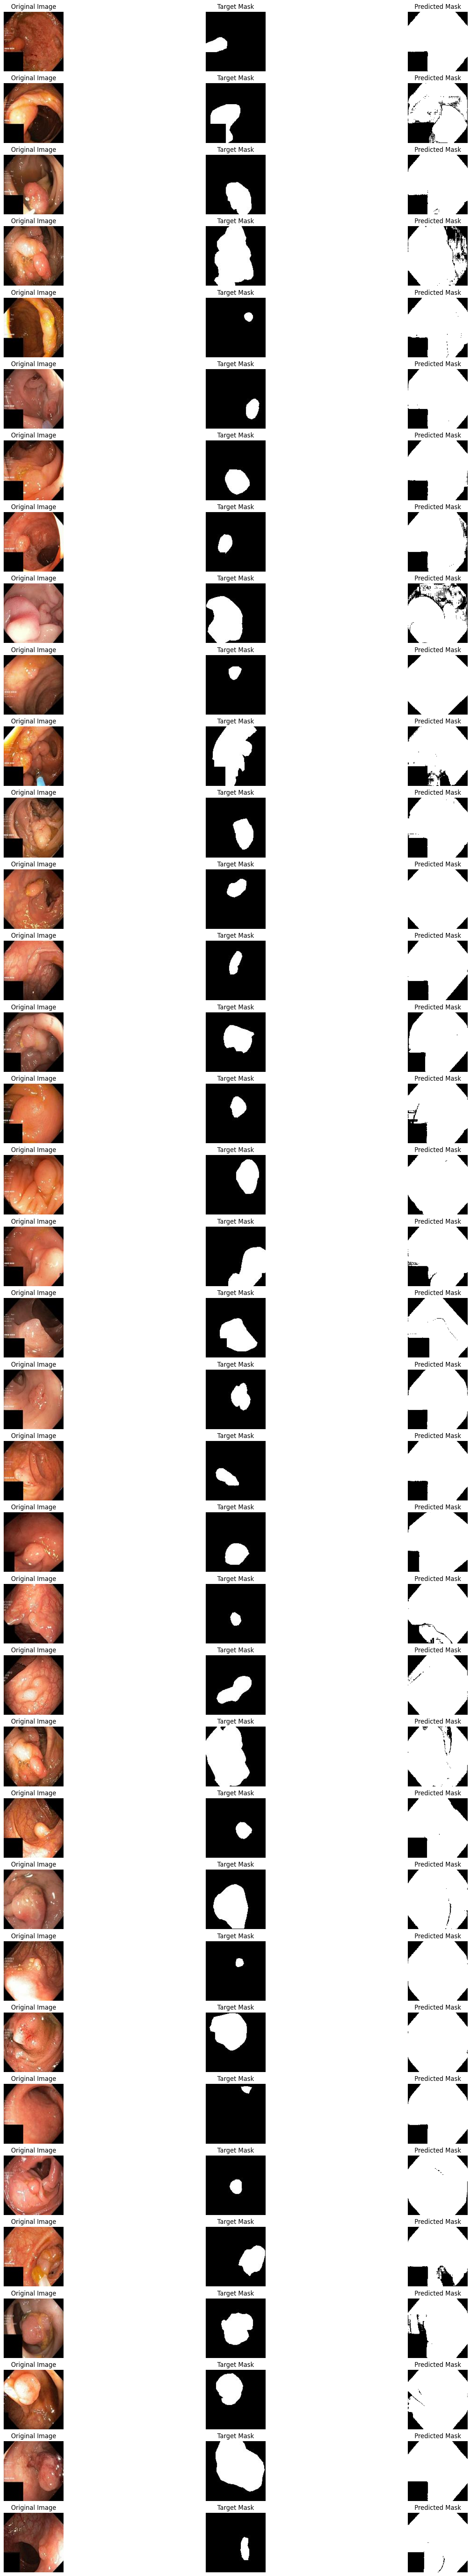

In [56]:
#visualize original images, prompt points, target masks and predicted masks of the test images
plt.figure(figsize=(20, 90))
# add title to the plot
for i in range(36):
    plt.subplot(36, 3, 3 * i + 1)
    plt.imshow(images_list_mem[i].squeeze(0))
    #plt.scatter(points_list[i][0][0].detach().cpu(), points_list[i][0][1].detach().cpu(), c="r", s=100, marker="x")
    plt.title(f"Original Image")
    plt.axis("off")
    plt.subplot(36, 3, 3 * i + 2)
    plt.imshow(target_masks_list[i][0], cmap='gray')
    plt.title("Target Mask")
    plt.axis("off")
    plt.subplot(36, 3, 3 * i + 3)
    plt.imshow(masks_list[i][0][0], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
plt.show()

In [42]:
len(ious_list)

182

In [43]:
# save ious_list in a csv file using pandas
df_ious = pd.DataFrame(ious_list)
df_ious.to_csv("RL_test_box_ious.csv", index=False)